In [1]:
# ### Install libraries ###

# !pip install git+https://github.com/HumanCompatibleAI/overcooked_ai.git

In [2]:
### Imports ###
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
# import sys
import pandas as pd
# import imageio
# sys.path.append("C:\\users\\mccar\\miniconda3\\lib\\site-packages")

# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import Adam
# from keras.models import load_model
# from keras.utils import plot_model
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv
from overcooked_ai_py.agents.agent import NNPolicy, AgentFromPolicy, AgentPair
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
import gym
import numpy as np
import torch
from PIL import Image
import os
from IPython.display import display, Image as IPImage

## Uncomment if you'd like to use your personal Google Drive to store outputs
## from your runs. You can find some hooks to Google Drive commented
## throughout the rest of this code.
# from google.colab import drive

In [3]:
### Environment setup ###

## Swap between the 3 layouts here:
layout = "cramped_room"
# layout = "asymmetric_advantages"
# layout = "forced_coordination"

## Reward shaping is disabled by default; i.e., only the sparse rewards are
## included in the reward returned by the enviornment).  If you'd like to do
## reward shaping (recommended to make the task much easier to solve), this
## data structure provides access to a built-in reward-shaping mechanism within
## the Overcooked environment.  You can, of course, do your own reward shaping
## in lieu of, or in addition to, using this structure. The shaped rewards
## provided by this structure will appear in a different place (see below)
reward_shaping = {
    "PLACEMENT_IN_POT_REW": 3,
    "DISH_PICKUP_REWARD": 3,
    "SOUP_PICKUP_REWARD": 5
}

# Length of Episodes.  Do not modify for your submission!
# Modification will result in a grading penalty!
horizon = 400

# Build the environment.  Do not modify!
mdp = OvercookedGridworld.from_layout_name(layout, rew_shaping_params=reward_shaping)
base_env = OvercookedEnv.from_mdp(mdp, horizon=horizon, info_level=0)
env = gym.make("Overcooked-v0", base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

Computing MotionPlanner to be saved in C:\Users\mccar\AppData\Local\Programs\Python\Python311\Lib\site-packages\overcooked_ai_py\data\planners\cramped_room_mp.pkl
It took 0.019922971725463867 seconds to create mp


C:\Users\mccar\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# Define the DQN model
class DQN_new(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN_new, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)

# Select action based on epsilon-greedy policy
def select_action(state, policy_net, epsilon, action_size):
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state).argmax().item()
    else:
        return random.randrange(action_size)

# Train the DQN
def optimize_model(policy_net, target_net, memory, batch_size, gamma, optimizer):
    if len(memory) < batch_size:
        return

    states, actions, rewards, next_states, dones = memory.sample(batch_size)
    
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach()
    expected_q_values = rewards + (gamma * next_q_values * (1 - dones))

    loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [5]:
# Training parameters
num_episodes = 50
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.9
target_update = 10
batch_size = 64
buffer_size = 1000
learning_rate = 0.001

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

policy_net = DQN_new(state_size, action_size)
target_net = DQN_new(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = ReplayBuffer(buffer_size)
epsilon = epsilon_start


for e in range(num_episodes):
    # Episode termination flag
    done = False

    # The number of soups the agent pair made during the episode
    num_soups_made = 0

    # Reset the environment at the start of each episode
    obs = env.reset()

    while not done:
        # Obtain observations for each agent
        obs0 = obs["both_agent_obs"][0]
        obs1 = obs["both_agent_obs"][1]

        # Convert observations to torch tensors
        state0 = torch.FloatTensor(obs0).unsqueeze(0)
        state1 = torch.FloatTensor(obs1).unsqueeze(0)

        # Select actions using the DQN
        a0 = select_action(state0, policy_net, epsilon, action_size)
        a1 = select_action(state1, policy_net, epsilon, action_size)

        # Take the selected actions and receive feedback from the environment
        obs, R, done, info = env.step([a0, a1])

        # Store the experience in replay buffer
        next_state0 = obs["both_agent_obs"][0]
        next_state1 = obs["both_agent_obs"][1]

        memory.push(obs0, a0, R, next_state0, done)
        memory.push(obs1, a1, R, next_state1, done)

        # Optimize the model
        optimize_model(policy_net, target_net, memory, batch_size, gamma, optimizer)

        # Update states
        obs0 = next_state0
        obs1 = next_state1

        # Accumulate the number of soups made
        num_soups_made += int(R / 20) # Each served soup generates 20 reward

    # Decay epsilon
    epsilon = max(epsilon_end, epsilon_decay * epsilon)

    # Update the target network
    if e % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Display status
    print("Ep {0}".format(e + 1), end=" ")
    print("shaped reward for agent 0: {0}:".format(info["shaped_r_by_agent"][0]), end=" ")
    print("shaped reward for agent 1: {0}".format(info["shaped_r_by_agent"][1]), end=" ")
    print("number of soups made: {0}".format(num_soups_made))

# The info flag returned by the environment contains special status info
# specifically when done == True. This information may be useful in
# developing, debugging, and analyzing your results. It may also be a good
# way for you to find a metric that you can use in evaluating collaboration
# between your agents.
print("\nExample end-of-episode info dump:\n", info)
# Save the trained models
torch.save(policy_net.state_dict(), 'qnn0.pth')
torch.save(policy_net.state_dict(), 'qnn1.pth')

Ep 1 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 2 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 3 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 4 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 5 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 6 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 7 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 8 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 9 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 10 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 11 shaped reward for agent 0: 0: shaped reward for agent 1: 0 number of soups made: 0
Ep 12 shaped reward for agent 

In [6]:
# DQN old

class DQN:
    def __init__(self, env, gamma=0.99, lr=1e-3, tau=1e-3):
        # set the environment
        self.env = env
        
        # Initialize the replay buffer
        self.replay_buffer = deque(maxlen=int(1e5))
        
        # discount factor gamma
        self.gamma = gamma
        # learning rate
        self.lr = lr
        # soft update rate
        self.tau = tau
        
        # construct the model and the target model
        self.model = self.init_model()
        self.target_model = self.init_model()
        self.optimizer = optim.Adam(params=self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
        # Every C steps, soft update target model
        self.C = 4
        # batch size for learning
        self.batch_size = 64
        # Counter
        self.t = 0

    def init_model(self):
        input_shape = self.env.observation_space.shape[0]
        output_shape = self.env.action_space.n
        
        model = nn.Sequential(
            nn.Linear(input_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_shape)
        )
        return model

    def add_to_buffer(self, state, action, reward, new_state, done):
        self.replay_buffer.append((state, action, reward, new_state, done))

    def generate_action(self, state, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state)
        with torch.no_grad():
            action = self.model(state).argmax().item()
        return action

    def train_target(self):
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def learning(self):
        self.t = (self.t + 1) % self.C
        
        if self.t == 0:
            if len(self.replay_buffer) < self.batch_size:
                return
            
            samples = random.sample(self.replay_buffer, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*samples)
            
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)

            q_values = self.model(states).squeeze(1).gather(1, actions).squeeze(1)
            next_q_values = self.target_model(next_states).squeeze(1).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
            
            loss = self.criterion(q_values, target_q_values.detach())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.train_target()

    def save_model(self, fn):
        torch.save(self.model.state_dict(), fn)

In [7]:
### Train your agent - Random visualizer ###

# drive.mount('/content/drive')
# !mkdir -p "/content/drive/My Drive/Colab"

# The code below runs a few episodes with a random agent.  Your learning algorithm
# would go here.

if False:
    num_episodes = 5


    for e in range(num_episodes):
        # Episode termination flag
        done = False

        # The number of soups the agent pair made during the episode
        num_soups_made = 0

        # Reset the environment at the start of each episode
        obs = env.reset()

        while not done:
            # Obtain observations for each agent
            obs0 = obs["both_agent_obs"][0]
            obs1 = obs["both_agent_obs"][1]

            # Select random actions from the set {North, South, East, West, Stay, Interact}
            # for each agent.
            a0 = env.action_space.sample()
            a1 = env.action_space.sample()

            # Take the selected actions and receive feedback from the environment
            # The returned reward "R" only reflects completed soups.
            obs, R, done, info = env.step([a0, a1])

            # You can find the separate shaping rewards induced by the data
            # structure you defined above in the "info" dictionary.
            ## THE REVERSAL OF THIS ARRAY IS NECESSARY TO ALIGN THE CORRECT REWARD
            ## TO THE CORRECT AGENT (see project documentation)!
            # Note that this shaping reward does *not* include the +20 reward for
            # completed soups (the one returned in "R").
            r_shaped = info["shaped_r_by_agent"]
            if env.agent_idx:
                r_shaped_0 = r_shaped[1]
                r_shaped_1 = r_shaped[0]
            else:
                r_shaped_0 = r_shaped[0]
                r_shaped_1 = r_shaped[1]

            # Accumulate the number of soups made
            num_soups_made += int(R / 20) # Each served soup generates 20 reward

        # Display status
        print("Ep {0}".format(e + 1), end=" ")
        print("shaped reward for agent 0: {0}:".format(r_shaped_0), end=" ")
        print("shaped reward for agent 1: {0}".format(r_shaped_1), end=" ")
        print("number of soups made: {0}".format(num_soups_made))

    # The info flag returned by the environemnt contains special status info
    # specifically when done == True.  This information may be useful in
    # developing, debugging, and analyzing your results.  It may also be a good
    # way for you to find a metric that you can use in evaluating collaboration
    # between your agents.
    print("\nExample end-of-episode info dump:\n", info)

In [8]:
### All of the remaining code in this notebook is solely for using the
### built-in Overcooked state visualizer on a trained agent, so that you can see
### a graphical rendering of what your agents are doing. It is not
### necessary to use this.

# The below code is a partcular way to rollout episodes in a format
# compatible with the built-in state visualizer.

class StudentPolicy(NNPolicy):
    """ Generate policy """
    def __init__(self, qnn0, qnn1):
        super(StudentPolicy, self).__init__()
        self.qnn0 = qnn0
        self.qnn1 = qnn1

    def state_policy(self, state, agent_index):
        """
        This method should be used to generate the poiicy vector corresponding to
        the state and agent_index provided as input.  If you're using a neural
        network-based solution, the specifics depend on the algorithm you are using.
        Below are two commented examples, the first for a policy gradient algorithm
        and the second for a value-based algorithm.  In policy gradient algorithms,
        the neural networks output a policy directly.  In value-based algorithms,
        the policy must be derived from the Q value outputs of the networks.  The
        uncommented code below is a placeholder that generates a random policy.
        """
        featurized_state = base_env.featurize_state_mdp(state)
        input_state = torch.FloatTensor(featurized_state[agent_index]).unsqueeze(0)

        action_probs = np.zeros(env.action_space.n)
        with torch.no_grad():
            if agent_index == 0:
                action_probs[np.argmax(self.qnn0(input_state)[0].numpy())] = 1
            else:
                action_probs[np.argmax(self.qnn1(input_state)[0].numpy())] = 1

        return action_probs

    def multi_state_policy(self, states, agent_indices):
        """ Generate a policy for a list of states and agent indices """
        return [self.state_policy(state, agent_index) for state, agent_index in zip(states, agent_indices)]


class StudentAgent(AgentFromPolicy):
    """Create an agent using the policy created by the class above"""
    def __init__(self, policy):
        super(StudentAgent, self).__init__(policy)


# Instantiate the DQN models for both agents
qnn0 = DQN_new(state_size, action_size)
qnn1 = DQN_new(state_size, action_size)

# Load trained models if available (for demonstration purposes we assume they are trained)
qnn0.load_state_dict(torch.load('qnn0.pth'))
qnn1.load_state_dict(torch.load('qnn1.pth'))

# Instantiate the policies for both agents
policy0 = StudentPolicy(qnn0, qnn1)
policy1 = StudentPolicy(qnn0, qnn1)

# Instantiate both agents
agent0 = StudentAgent(policy0)
agent1 = StudentAgent(policy1)
agent_pair = AgentPair(agent0, agent1)

# Generate an episode
horizon = 400
ae = AgentEvaluator.from_layout_name({"layout_name": layout}, {"horizon": horizon})
trajs = ae.evaluate_agent_pair(agent_pair, num_games=1)
print("\nlen(trajs):", len(trajs))

  0%|          | 0/1 [00:00<?, ?it/s]

Computing MotionPlanner to be saved in C:\Users\mccar\AppData\Local\Programs\Python\Python311\Lib\site-packages\overcooked_ai_py\data\planners\cramped_room_mp.pkl
It took 0.045073747634887695 seconds to create mp


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


len(trajs): 10


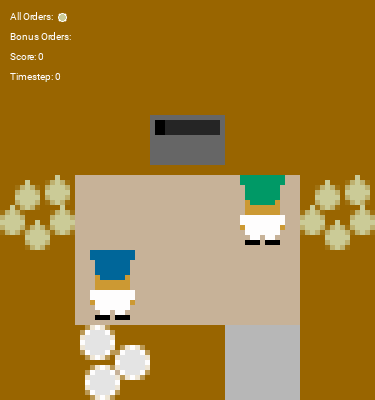

In [9]:
# The function StateVisualizer() below generates images for the state of the
# environment at each time step of the episode.
#
# You have several options for how to use these images:
#
# 1) You can set img_dir to a local directory (or a directory within Google Drive
# if using Colab), and all the images will be saved to that directory for you to browse.
#
# 2) If using a notebook, you can set the argument ipthon_display=True to get a
# tool with a slider that lets you scan through all the images directly in the
# notebook.  This option does not require you to store your images.
#
# 3) You can generate a GIF of the episode. This requires you to set
# img_dir.  The code to generate the GIF is commented out below

# Modify as appropriate. Example hooks to Google drive are commented.
img_dir =  "imgs/" # "/content/drive/My Drive/Colab/" + "imgs_" + layout + "/"
ipython_display = True
gif_path = "imgs/imgs.gif" # "/content/drive/My Drive/Colab/" + layout + ".gif"

# StateVisualizer().display_rendered_trajectory(trajs, img_directory_path=img_dir, ipython_display=ipython_display)

## Uncomment for GIF to be generated and stored in 'gif_path'. Requires 'img_dir'
## to point to a directory of saved images.
# img_list = [f for f in os.listdir(img_dir) if f.endswith('.png')]
# img_list = sorted(img_list, key=lambda x: int(x.split('.')[0]))
# images = [Image.open(img_dir + img).convert('RGBA') for img in img_list]
# images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=250, loop=0)
with open(gif_path, 'rb') as f: display(IPImage(data=f.read(), format='png'))